# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import csv
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from matplotlib import pyplot as plt
import seaborn as sns

from wordcloud import WordCloud


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin-1')
test = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding='latin-1')

In [3]:
train.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


In [4]:
train.columns


Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [5]:
train = train.drop(columns = 'UserName')
train = train.drop(columns = 'ScreenName')
train = train.drop(columns = 'Location')
train = train.drop(columns = 'TweetAt')


In [6]:
test = test.drop(columns = 'UserName')
test = test.drop(columns = 'ScreenName')
test = test.drop(columns = 'Location')
test = test.drop(columns = 'TweetAt')


In [7]:
train['Sentiment'].value_counts()


Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [8]:
train.shape, test.shape


((41157, 2), (3798, 2))

In [9]:
train0=train[train['Sentiment']=='Positive']
train1=train[train['Sentiment']=='Negative']
train2=train[train['Sentiment']=='Neutral']
train3=train[train['Sentiment']=='Extremely Positive']
train4=train[train['Sentiment']=='Extremely Negative']

In [10]:
train0.iloc[0]['OriginalTweet']

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [11]:
train1.iloc[0]['OriginalTweet']

"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona"

In [12]:
train2.iloc[0]['OriginalTweet']

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [13]:
train0.shape, train1.shape, train2.shape, train3.shape, train4.shape

((11422, 2), (9917, 2), (7713, 2), (6624, 2), (5481, 2))

In [14]:
train = pd.concat([train0, train1, train2, train3, train4])


In [15]:
train.loc[4, 'OriginalTweet']

"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n"

# Pre-Processing Data

In [16]:
#Remove Hashtags
train['OriginalTweet'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)

#Remove Mention
train['OriginalTweet'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)

#Remove URL
train['OriginalTweet'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

train['OriginalTweet']=train['OriginalTweet'].str.lower()

#Remove Punctuations
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [17]:
#Remove Hashtags
test['OriginalTweet'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)

#Remove Mention
test['OriginalTweet'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)

#Remove URL
test['OriginalTweet'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

test['OriginalTweet']=test['OriginalTweet'].str.lower()

#Remove Punctuations
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [18]:
stemmer = PorterStemmer()
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [19]:
stop = stopwords.words('english')

train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [20]:
train.loc[4, 'OriginalTweet']

'readi go supermarket dure outbreak becaus im paranoid becaus food stock litterali empti seriou thing pleas dont panic caus shortag httpstcousmualq72n'

In [21]:
train.loc[0, 'OriginalTweet']

'httpstcoifz9fan2pa httpstcoxx6ghgfzcc httpstcoi2nlzdxno8'

# Post EDA

In [22]:
train.head(20)

,OriginalTweet,Sentiment
1,advic talk neighbour famili exchang phone numb...,Positive
2,coronaviru australia woolworth give elderli di...,Positive
3,food stock onli one empti pleas dont panic eno...,Positive
5,news regionâ first confirm covid19 case came ...,Positive
6,cashier groceri store wa share hi insight prov...,Positive
8,due covid19 retail store classroom atlanta ope...,Positive
13,dont need stock food ill amazon deliv whatev n...,Positive
14,adara releas covid19 resourc center travel bra...,Positive
15,line groceri store unpredict eat safe altern f...,Positive
19,arent struggl pleas consid donat food bank non...,Positive


In [23]:
train.describe()

,OriginalTweet,Sentiment
count,41157,41157
unique,41056,5
top,,Positive
freq,15,11422


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 1 to 41153
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [25]:
train.nunique()

OriginalTweet    41056
Sentiment            5
dtype: int64

In [26]:
train.shape

(41157, 2)

In [27]:
nullValues = (train.isnull().sum()/len(train)*100).sort_values(ascending = False)
nullValues

OriginalTweet    0.0
Sentiment        0.0
dtype: float64

In [28]:
# Replace "Extremely Positive" with "Positive"
train['Sentiment'] = train['Sentiment'].replace({'Extremely Positive': 'Positive', 'Neutral': 'Positive'})

# Replace "Extremely Negative" with "Negative"
train['Sentiment'] = train['Sentiment'].replace('Extremely Negative', 'Negative',)

In [29]:
# Replace "Extremely Positive" with "Positive"
test['Sentiment'] = test['Sentiment'].replace({'Extremely Positive': 'Positive', 'Neutral': 'Positive'})

# Replace "Extremely Negative" with "Negative"
test['Sentiment'] = test['Sentiment'].replace('Extremely Negative', 'Negative')

In [30]:
sentimentClass = train['Sentiment'].value_counts();
sentimentClass

Positive    25759
Negative    15398
Name: Sentiment, dtype: int64

In [31]:
sentimentClass = test['Sentiment'].value_counts();
sentimentClass

Positive    2165
Negative    1633
Name: Sentiment, dtype: int64

# **Distribution of sentiment categories using a bar plot**

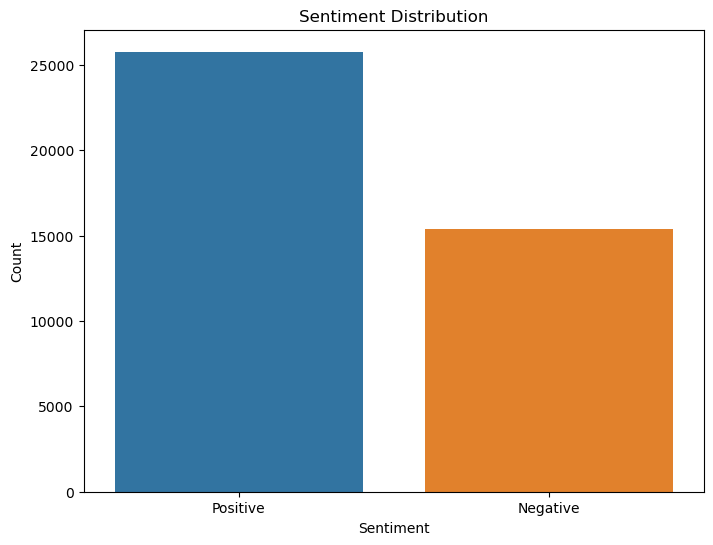

In [32]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='Sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Word Cloud

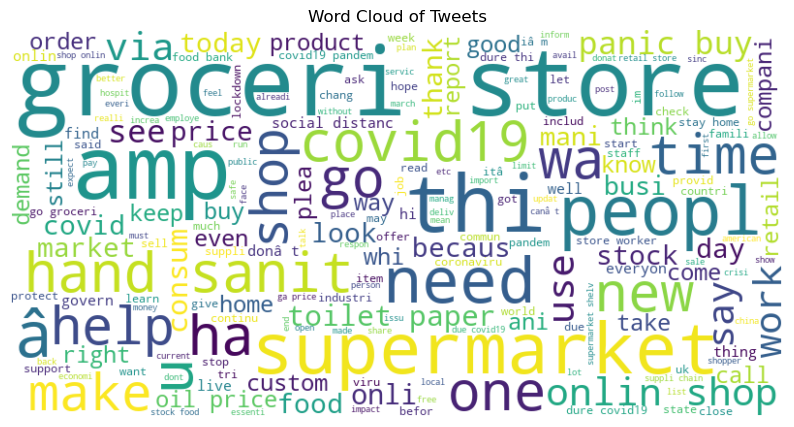

In [33]:
all_tweets_text = " ".join(tweet for tweet in train['OriginalTweet'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets_text)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

In [34]:
x = train['OriginalTweet']
y = train['Sentiment']

In [35]:
train_bgw = train

In [36]:
y_bgw = y

In [37]:
x.shape

(41157,)

# Vectorization

## TF-IDF 

In [38]:
corpus = []
for i in range(x.shape[0]):
    corpus.append(x.iloc[i])

In [39]:
vectorizer1 = TfidfVectorizer(max_features=1000)
X1 = vectorizer1.fit_transform(x)
feature_names1 = vectorizer1.get_feature_names_out()
denselist1 = X1.todense().tolist()
train = pd.DataFrame(denselist1, columns=feature_names1)

In [40]:
X_temp, X_test, y_temp, y_test = train_test_split(train, y, test_size=0.2, random_state=0)


In [41]:
accuracy = {'TF-IDF':[]}


# Models

## Logistic Regression

In [42]:
regressor_LR_tf = LogisticRegression(C=1.0,penalty='l2',solver='newton-cg')
regressor_LR_tf.fit(X_temp, y_temp)
y_predict_LR_tf = regressor_LR_tf.predict(X_test)
a=(regressor_LR_tf.score(X_test, y_test))
accuracy['TF-IDF'].append(a)

print(metrics.accuracy_score(y_test, y_predict_LR_tf))

0.8264091350826045


## Decision Tree

In [43]:
model_DT_tf = DecisionTreeClassifier(criterion = 'gini', max_depth=2) 
model_DT_tf.fit(X_temp, y_temp)
y_predict_DT_tf = model_DT_tf.predict(X_test)
a=(model_DT_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.accuracy_score(y_test, y_predict_DT_tf))

0.6932701652089407


## Gradient Boosting 

In [44]:
model_GB_tf = GradientBoostingClassifier(learning_rate= 0.1, max_depth=3, n_estimators= 100,subsample=1.0) 
model_GB_tf.fit(X_temp, y_temp)
y_predict_GB_tf = model_GB_tf.predict(X_test)
a=(model_GB_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.accuracy_score(y_test, y_predict_GB_tf))

0.761418853255588


## Random Forest

In [45]:
model_RF_tf = RandomForestClassifier(n_estimators= 100, max_features = 'log2')
model_RF_tf.fit(X_temp, y_temp)
y_predict_RF_tf = model_RF_tf.predict(X_test)
a=(model_RF_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.accuracy_score(y_test, y_predict_RF_tf))

0.8137755102040817


## K Nearest Neighbour

In [46]:
model_KN_tf = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 5, weights= 'distance') 
model_KN_tf.fit(X_temp, y_temp)
y_predict_KN_tf = model_KN_tf.predict(X_test)
a=(model_KN_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.accuracy_score(y_test, y_predict_KN_tf))

0.6704324586977648


# Evaluation

In [47]:
model = ['LR','DT','GB','RF','KN']
data = {'model': model,'accuracy': accuracy['TF-IDF']}
compare_models = pd.DataFrame(data)
compare_models

,model,accuracy
0,LR,0.826409
1,DT,0.693270
2,GB,0.761419
3,RF,0.813776
4,KN,0.670432


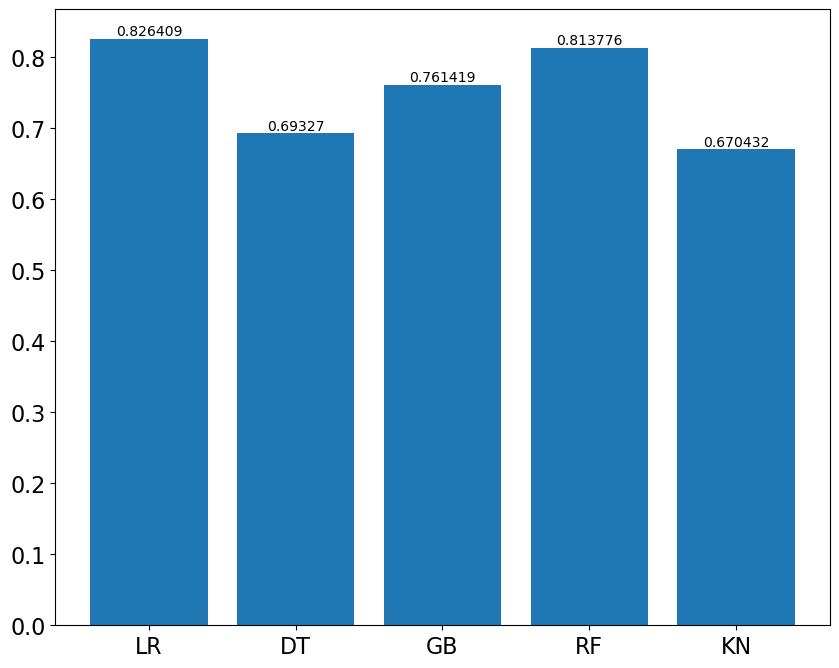

In [48]:
x, y = compare_models['model'],compare_models['accuracy']
ind = np.arange(len(y))
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(ind, y)
ax.set_xticks(ind)
ax.set_xticklabels(x)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()
#fig.savefig('Comparision of Models, TFIDF.pdf', format='pdf', bbox_inches = "tight")

## BoW

In [49]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(train_bgw, y_bgw, test_size=0.2, random_state=0)


In [50]:
X_test.shape, X_temp.shape, len(y_test), len(y_temp)


((8232, 2), (32925, 2), 8232, 32925)

In [51]:
X_temp['label'] = y_temp


In [52]:
X_temp.head()

,OriginalTweet,Sentiment,label
26225,world could soon run space store oil may plung...,Negative,Negative
23163,stay safe indoor familyâ medic deliv offer lo...,Positive,Positive
38100,ubiquit latex plexiglass barrier forc tape sup...,Negative,Negative
22569,check new blog post httpstconfogpcufp7,Positive,Positive
7883,billionair jack maâ foundat donat mask test k...,Positive,Positive


In [53]:
X_temp.head()

,OriginalTweet,Sentiment,label
26225,world could soon run space store oil may plung...,Negative,Negative
23163,stay safe indoor familyâ medic deliv offer lo...,Positive,Positive
38100,ubiquit latex plexiglass barrier forc tape sup...,Negative,Negative
22569,check new blog post httpstconfogpcufp7,Positive,Positive
7883,billionair jack maâ foundat donat mask test k...,Positive,Positive


In [54]:
Positive = X_temp[X_temp['label'] == 'Positive']
Negative = X_temp[X_temp['label'] == 'Negative']

Positive.shape[0], Negative.shape[0]

(20514, 12411)

In [55]:
testdf = X_test
testdf['label'] = y_test
testdf.shape

(8232, 3)

In [56]:
ds = pd.concat([Positive, Negative], axis = 0)


In [57]:
ds

,OriginalTweet,Sentiment,label
23163,stay safe indoor familyâ medic deliv offer lo...,Positive,Positive
22569,check new blog post httpstconfogpcufp7,Positive,Positive
7883,billionair jack maâ foundat donat mask test k...,Positive,Positive
36543,know amaz effort thi advers httpstcowvvydjcu20,Positive,Positive
13620,thank groceri store worker dont know,Positive,Positive
...,...,...,...
27257,know disgust groceri store rais price milk egg...,Negative,Negative
15973,stop hoard u r caus problem 4peopl canât get ...,Negative,Negative
13897,dane solv supermarket price sanit 1x 5dkk 2x 1...,Negative,Negative
38713,linger air longer previous thought scientist w...,Negative,Negative


In [58]:
corpus = []
for i in range(ds.shape[0]):
    corpus.append(ds.iloc[i][0])

In [59]:
vectorizer_train = CountVectorizer(max_features=1000)
vocabulary_train = vectorizer_train.fit_transform(corpus)
bow = pd.DataFrame(vocabulary_train.toarray(), columns = vectorizer_train.get_feature_names_out())

In [60]:
bow['labelxyz'] = list(ds.label)

In [61]:
bow_positive = bow[bow.labelxyz == 'Positive']
bow_negative = bow[bow.labelxyz == 'Negative']
bow_neutral = bow[bow.labelxyz == 'Neutral']

X_train_positive = bow_positive.sample(frac=0.8, random_state=0)
X_test_positive = bow_positive.drop(X_train_positive.index)
X_train_negative = bow_negative.sample(frac=0.8, random_state=0)
X_test_negative = bow_negative.drop(X_train_negative.index)
X_train_neutral = bow_neutral.sample(frac=0.8, random_state=0)
X_test_neutral = bow_neutral.drop(X_train_neutral.index)


X_train_df = pd.concat([X_train_positive, X_train_negative, X_train_neutral], axis = 0)
bow_train = X_train_df.drop(['labelxyz'], axis = 1)
y_train = list(X_train_df.labelxyz)
X_test_df = pd.concat([X_test_positive, X_test_negative, X_test_neutral], axis = 0)
bow_test = X_test_df.drop(['labelxyz'], axis = 1)
y_test = list(X_test_df.labelxyz)

In [62]:
model = ['LR','RF','DT','KN','GB']
accuracy = {'BOW':[]}

# Models

## Logistic Regression

In [63]:
regressor_LR_bow = LogisticRegression(C= 1.0, penalty='l2', solver= 'liblinear')
regressor_LR_bow.fit(bow_train,y_train)
y_predict_LR_bow = regressor_LR_bow.predict(bow_test)
a=(regressor_LR_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)

print(metrics.accuracy_score(y_test, y_predict_LR_bow))

0.8223234624145785


# **Decision Tree**

In [64]:
model_DT_bow = DecisionTreeClassifier(criterion= 'gini', max_depth= 2) 
model_DT_bow.fit(bow_train,y_train)
y_predict_DT_bow = model_DT_bow.predict(bow_test)
a=(model_DT_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)

print(metrics.accuracy_score(y_test, y_predict_DT_bow))

0.6772968868640851


# **Gradient Boosting**

In [65]:
model_GB_bow = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 100, subsample= 1.0)
model_GB_bow.fit(bow_train,y_train)
y_predict_GB_bow = model_GB_bow.predict(bow_test)
a=(model_GB_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)

print(metrics.accuracy_score(y_test, y_predict_GB_bow))

0.7491268033409263


## Random Forest

In [66]:
model_RF_bow = RandomForestClassifier(max_features='sqrt', n_estimators= 1000)
model_RF_bow.fit(bow_train,y_train)
y_predict_RF_bow = model_RF_bow.predict(bow_test)
a=(model_RF_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)

print(metrics.accuracy_score(y_test, y_predict_RF_bow))

0.8069855732725892


## K Neighbours

In [67]:
model_KN_bow = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 19, weights= 'distance') 
model_KN_bow.fit(bow_train,y_train)
y_predict_KN_bow = model_KN_bow.predict(bow_test)
a=(model_KN_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)

print(metrics.accuracy_score(y_test, y_predict_KN_bow))

0.6660592255125285


## Evaluation

In [68]:
data_bow = {'model':model,'accuracy':accuracy['BOW']}
compare_models_bow = pd.DataFrame(data_bow)
compare_models_bow

,model,accuracy
0,LR,0.822323
1,RF,0.677297
2,DT,0.749127
3,KN,0.806986
4,GB,0.666059


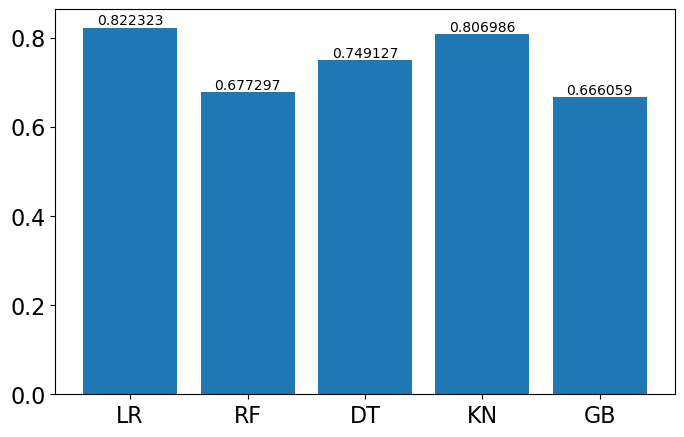

In [69]:
x, y = compare_models_bow['model'],compare_models_bow['accuracy']
ind = np.arange(len(y))
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(ind, y)
ax.set_xticks(ind)
ax.set_xticklabels(x)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()
fig.savefig('Comparision of Models, BoW.pdf', format='pdf')

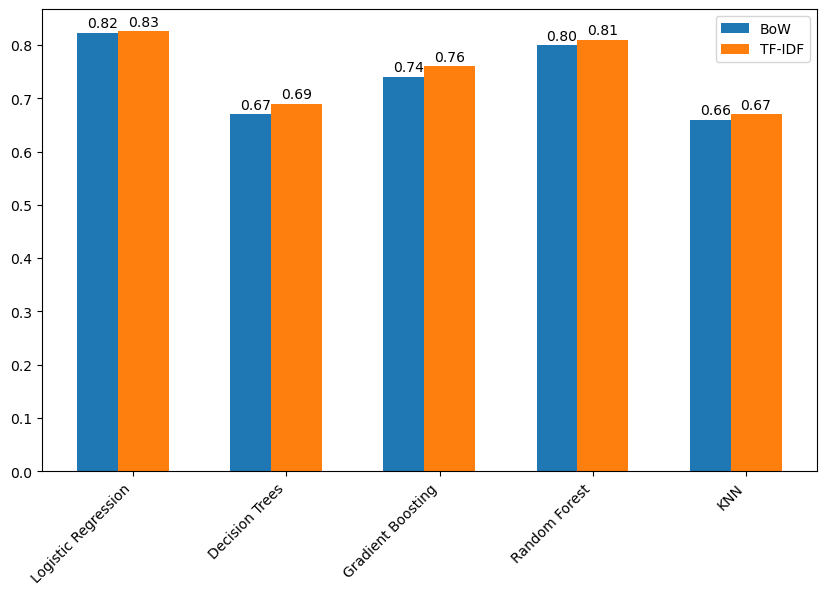

In [70]:
import matplotlib.pyplot as plt
import numpy as np

model = ['Logistic Regression', 'Decision Trees', 'Gradient Boosting', 'Random Forest', 'KNN']
position1 = np.arange(len(model)) * 1.5  # Increased spacing by multiplying by a factor
position2 = [x + 0.4 for x in position1]  # Shifted by 0.6 for side-by-side placement

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Correct way to set figsize

accuracy_tfidf = [0.826, 0.69, 0.76, 0.81, 0.67]  # Accuracy for tfidf
accuracy_bow = [0.823, 0.67, 0.74, 0.80, 0.66]    # Accuracy for bow

# Plot the bars
ax.bar(position1, accuracy_bow, width=0.5, label='BoW')  # Corrected the label
ax.bar(position2, accuracy_tfidf, width=0.5, label='TF-IDF')

# Set the x-axis tick positions and labels
ax.set_xticks([p + 0.3 for p in position1])  # Centering the ticks
ax.set_xticklabels(model, rotation=45, ha="right")  # Rotating labels for better readability

# Add data labels to the bars
for i in range(len(model)):
    ax.text(position1[i], accuracy_bow[i] + 0.01, f"{accuracy_bow[i]:.2f}", ha="center")
    ax.text(position2[i], accuracy_tfidf[i] + 0.01, f"{accuracy_tfidf[i]:.2f}", ha="center")

# Add legend
ax.legend()

# Display the plot
plt.show()
